In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scipy.stats

In [14]:
class MapReduceSalesReader:

    def __init__(self, input_folder: Path):
        self.input_folder = input_folder

    def read_sales(self):
        for file in self.input_folder.iterdir():
            if not file.is_file() or not file.name.endswith(".csv"):
                print(f"Skipping {file.name}")
                continue
            chunk = pd.read_csv(file, parse_dates=["sale_time"])
            chunk["day"] = pd.to_datetime(chunk["sale_time"].dt.date)
            chunk["hour"] = chunk["sale_time"].dt.hour
            yield chunk

    def map_reduce(self, map_function, reduce_function, init_aggregate=None):
        total_aggregation = init_aggregate
        for chunk in self.read_sales():
            chunk_aggregate = map_function(chunk)
            total_aggregation = reduce_function(total_aggregation, chunk_aggregate)
        return total_aggregation



In [15]:
reader = MapReduceSalesReader(Path("datasets/"))

# Q: Plot daily sales for all 50 weeks

In [23]:
def count_per_day(chunk:pd.DataFrame):
    chunk = chunk[["day", "purchaser_gender"]].groupby("day").count()
    chunk = chunk.rename({"purchaser_gender":"sales_per_day"}, axis=1)
    return chunk

def reduce_per_day_counts(aggregate:pd.DataFrame, chunk:pd.DataFrame):
    return chunk.add(aggregate, fill_value=0)

daily_counts = reader.map_reduce(count_per_day, reduce_per_day_counts, init_aggregate=0)


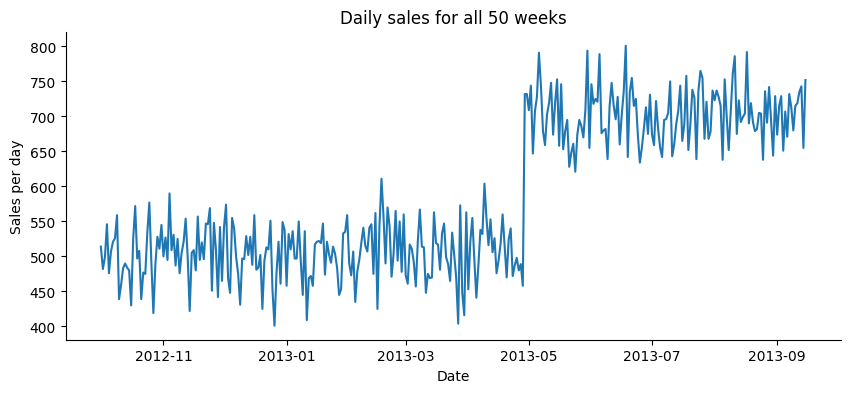

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(daily_counts)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Sales per day")
plt.xlabel("Date")
plt.title("Daily sales for all 50 weeks")
plt.show()

# Q: It looks like there has been a sudden change in daily sales. What date did it occur?

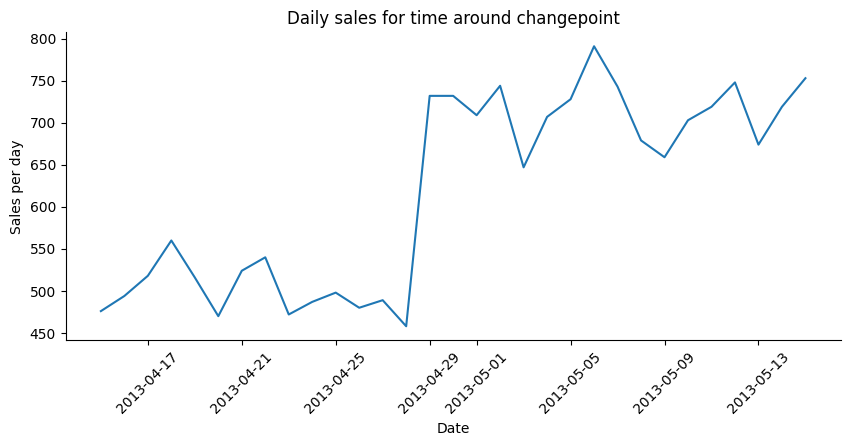

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
subset_counts = daily_counts["2013-04-15":"2013-05-15"]
plt.plot(subset_counts)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Sales per day")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Daily sales for time around changepoint")
plt.show()

### Answer: The first day of the higher sales count appears to be 2013-04-29

# Q: Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?

In [26]:
# By the way, I checked, they are both inclusive ranges
date_before = "2013-04-28"
date_after = "2013-04-29"
daily_sales_before = daily_counts[:date_before]
daily_sales_after = daily_counts[date_after:]

#### Check for normality, using shapiro-wilk test, alpha=0.05

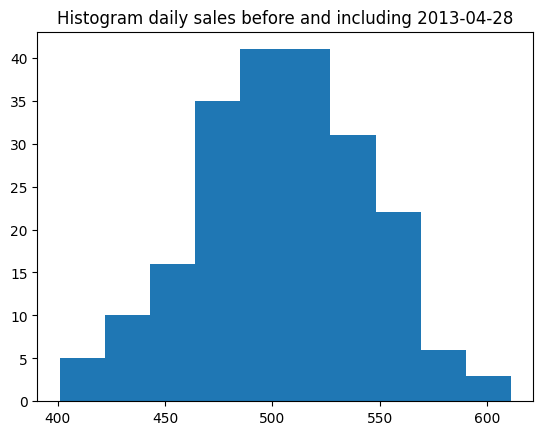

ShapiroResult(statistic=0.9947191476821899, pvalue=0.674348771572113)

In [27]:
plt.hist(daily_sales_before)
plt.title("Histogram daily sales before and including 2013-04-28")
plt.show()
scipy.stats.shapiro(daily_sales_before["sales_per_day"])

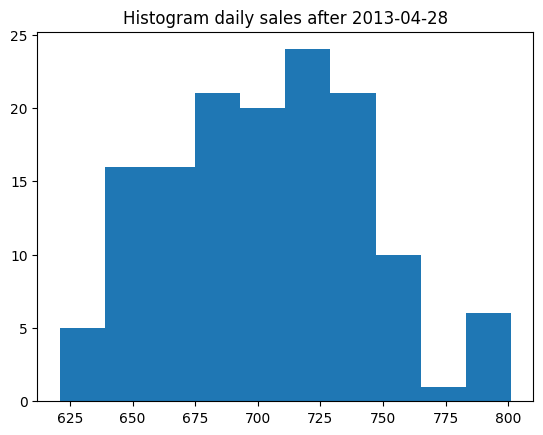

ShapiroResult(statistic=0.9842513203620911, pvalue=0.10845467448234558)

In [28]:
plt.hist(daily_sales_after)
plt.title("Histogram daily sales after 2013-04-28")
plt.show()
scipy.stats.shapiro(daily_sales_after["sales_per_day"])

#### Both sets do not significantly deviate from a normal distribution (pvals: 0.67 and 0.10). Both before and after appear to be normally distributed (although for the sales after it's a bit wonky). Therefore a t-test is justified.

In [29]:
scipy.stats.ttest_ind(daily_sales_before["sales_per_day"], daily_sales_after["sales_per_day"], alternative="two-sided")

Ttest_indResult(statistic=-45.7865380479371, pvalue=2.27287631770394e-149)

## Answer: Daily sales difference between two time ranges is statistically significant, p-value < 0.05

# Q: Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).

In [30]:
def count_daily_sales_per_gender(chunk:pd.DataFrame):
    chunk["daily_count"] = 1
    chunk = chunk[["purchaser_gender", "day", "daily_count"]]
    chunk = chunk.groupby(["purchaser_gender", "day"]).count()
    return chunk

daily_sales_per_gender = reader.map_reduce(count_daily_sales_per_gender,
                                            reduce_per_day_counts,
                                            init_aggregate=0)


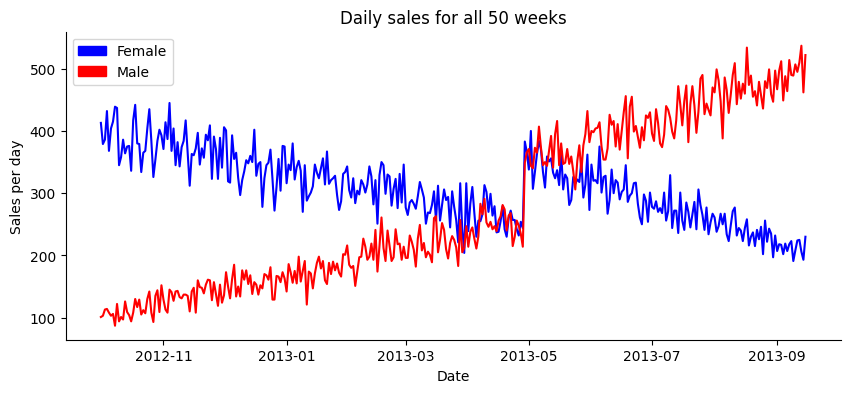

In [31]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(daily_sales_per_gender.loc["female"], label="Female", color="blue")
plt.plot(daily_sales_per_gender.loc["male"], label="Male", color="red")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Sales per day")
plt.xlabel("Date")
plt.title("Daily sales for all 50 weeks")
legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Female'),
                   Patch(facecolor='red', edgecolor='red',
                         label='Male')]
plt.legend(handles=legend_elements)
plt.show()

## Answer: Female sales have been dropped continuously while male sales increased. The sudden total increase is **not** explained by a matching sudden change in gender ratio.

# Q: What is the percentage of sales in each daypart over all 50 weeks?

In [32]:
def count_sales_per_daytime(chunk:pd.DataFrame):
    mapping = dict()
    mapping["night"] = sum((chunk["hour"] >=0) & (chunk["hour"] < 6))
    mapping["morning"] = sum((chunk["hour"] >=6) & (chunk["hour"] < 12))
    mapping["afternoon"] = sum((chunk["hour"] >=12) & (chunk["hour"] < 18))
    mapping["evening"] = sum((chunk["hour"] >=18) & (chunk["hour"] <= 23))
    return mapping

def reduce_per_daytime_counts(aggregate:dict, chunk:dict):
    return {k: aggregate[k]+chunk[k] for k in chunk}


sales_per_daytime = reader.map_reduce(count_sales_per_daytime,
                                            reduce_per_daytime_counts,
                                            init_aggregate={"night":0, "morning":0, "afternoon":0, "evening":0})
total_sales = sum(sales_per_daytime.values())
sales_per_daytime_percent = {k:(v/total_sales)*100 for k,v in sales_per_daytime.items()}

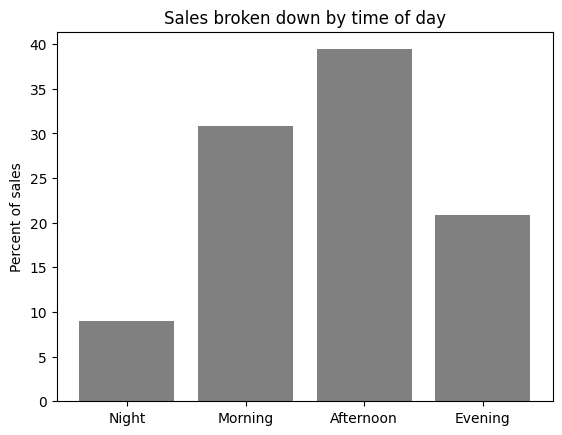

In [33]:
plt.figure()
plt.bar(x=0, height=sales_per_daytime_percent["night"], color="grey")
plt.bar(x=1, height=sales_per_daytime_percent["morning"], color="grey")
plt.bar(x=2, height=sales_per_daytime_percent["afternoon"], color="grey")
plt.bar(x=3, height=sales_per_daytime_percent["evening"], color="grey")
plt.xticks(ticks=[0,1,2,3], labels=["Night", "Morning", "Afternoon", "Evening"])
plt.ylabel("Percent of sales")
plt.title("Sales broken down by time of day")
plt.show()

In [41]:
def count_sales_per_daytime(chunk:pd.DataFrame):
    chunk["daytime"] = ""
    chunk.loc[(chunk["hour"] >=0) & (chunk["hour"] < 6),"daytime"] = "Night"
    chunk.loc[(chunk["hour"] >=6) & (chunk["hour"] < 12),"daytime"] = "Morning"
    chunk.loc[(chunk["hour"] >=12) & (chunk["hour"] < 18),"daytime"] = "Afternoon"
    chunk.loc[(chunk["hour"] >=18) & (chunk["hour"] <= 23),"daytime"] = "Evening"

    chunk["daytime_count"] = 1
    chunk = chunk[["day", "daytime", "daytime_count"]]
    chunk = chunk.groupby(["daytime", "day"]).count()

    return chunk


sales_per_daytime = reader.map_reduce(count_sales_per_daytime,
                                            reduce_per_day_counts,
                                            init_aggregate=0)


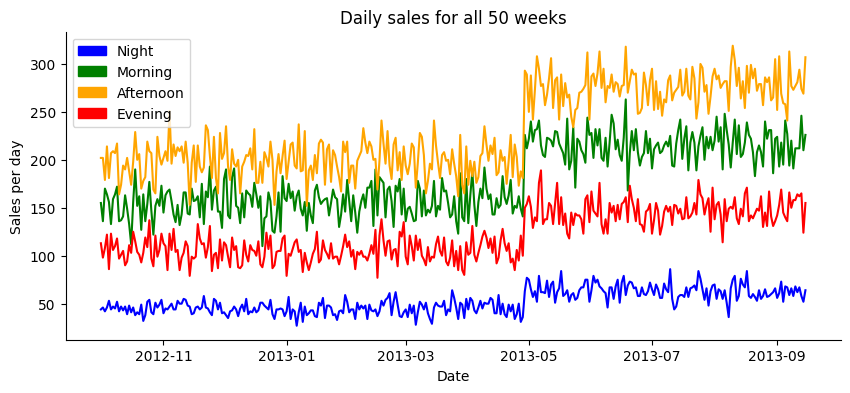

In [42]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(sales_per_daytime.loc["Night"], label="Night", color="blue")
plt.plot(sales_per_daytime.loc["Morning"], label="Morning", color="green")
plt.plot(sales_per_daytime.loc["Afternoon"], label="Afternoon", color="orange")
plt.plot(sales_per_daytime.loc["Evening"], label="Evening", color="red")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Sales per day")
plt.xlabel("Date")
plt.title("Daily sales for all 50 weeks")
legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Night'),
                   Patch(facecolor='green', edgecolor='green', label='Morning'),
                   Patch(facecolor='orange', edgecolor='orange', label='Afternoon'),
                   Patch(facecolor='red', edgecolor='red', label='Evening'),
                   ]
plt.legend(handles=legend_elements)
plt.show()